In [23]:
import os
import re

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.externals import joblib
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [372]:
data = pd.read_csv('out.csv', nrows=200000)

/anaconda3/envs/python-cvcourse/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (12,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
data.head()

,key,is_purchase,status,company,premium,sum,action_type,is_partner,created_at,init_from,...,place,is_foreigner,sports,adult,child,ip,referer,user_agent,timezone,is_adblock_enabled
0,4601,True,SENT,RES,417.6,300000.0,ALWAYS,False,1559590087,2019-06-09,...,NaN,False,SHESTOVAYA-AKROBATIKA--POLDENS-POLE-DANCE-PILON-,1,0,213.87.128.216,https://prosto.insure/sportivnaja-strakhovka/s...,Mozilla/5.0 (Linux; Android 8.0.0; VTR-L29) Ap...,180.0,False
1,4601,True,CALCULATE,RES,417.6,300000.0,ALWAYS,False,1559589752,2019-06-09,...,NaN,False,SHESTOVAYA-AKROBATIKA--POLDENS-POLE-DANCE-PILON-,1,0,213.87.128.216,https://prosto.insure/sportivnaja-strakhovka/s...,Mozilla/5.0 (Linux; Android 8.0.0; VTR-L29) Ap...,180.0,False
2,4601,True,CALCULATE,RES,417.6,300000.0,ALWAYS,False,1559589752,2019-06-09,...,NaN,False,SHESTOVAYA-AKROBATIKA--POLDENS-POLE-DANCE-PILON-,1,0,213.87.128.216,https://prosto.insure/sportivnaja-strakhovka/s...,Mozilla/5.0 (Linux; Android 8.0.0; VTR-L29) Ap...,180.0,False
3,4601,True,CALCULATE,VTB,874.0,300000.0,ALWAYS,False,1559589752,2019-06-09,...,NaN,False,SHESTOVAYA-AKROBATIKA--POLDENS-POLE-DANCE-PILON-,1,0,213.87.128.216,https://prosto.insure/sportivnaja-strakhovka/s...,Mozilla/5.0 (Linux; Android 8.0.0; VTR-L29) Ap...,180.0,False
4,4601,True,CALCULATE,ZET,810.0,300000.0,ALWAYS,False,1559589752,2019-06-09,...,NaN,False,SHESTOVAYA-AKROBATIKA--POLDENS-POLE-DANCE-PILON-,1,0,213.87.128.216,https://prosto.insure/sportivnaja-strakhovka/s...,Mozilla/5.0 (Linux; Android 8.0.0; VTR-L29) Ap...,180.0,False


In [76]:
def correlation_plot(data):
    
    data = data.drop(['key', 'created_at', 'init_from', 'init_till', 'year', 'place', 'timezone', 'is_adblock_enabled', 'ip'], axis=1)
    
    sns.pairplot(data)

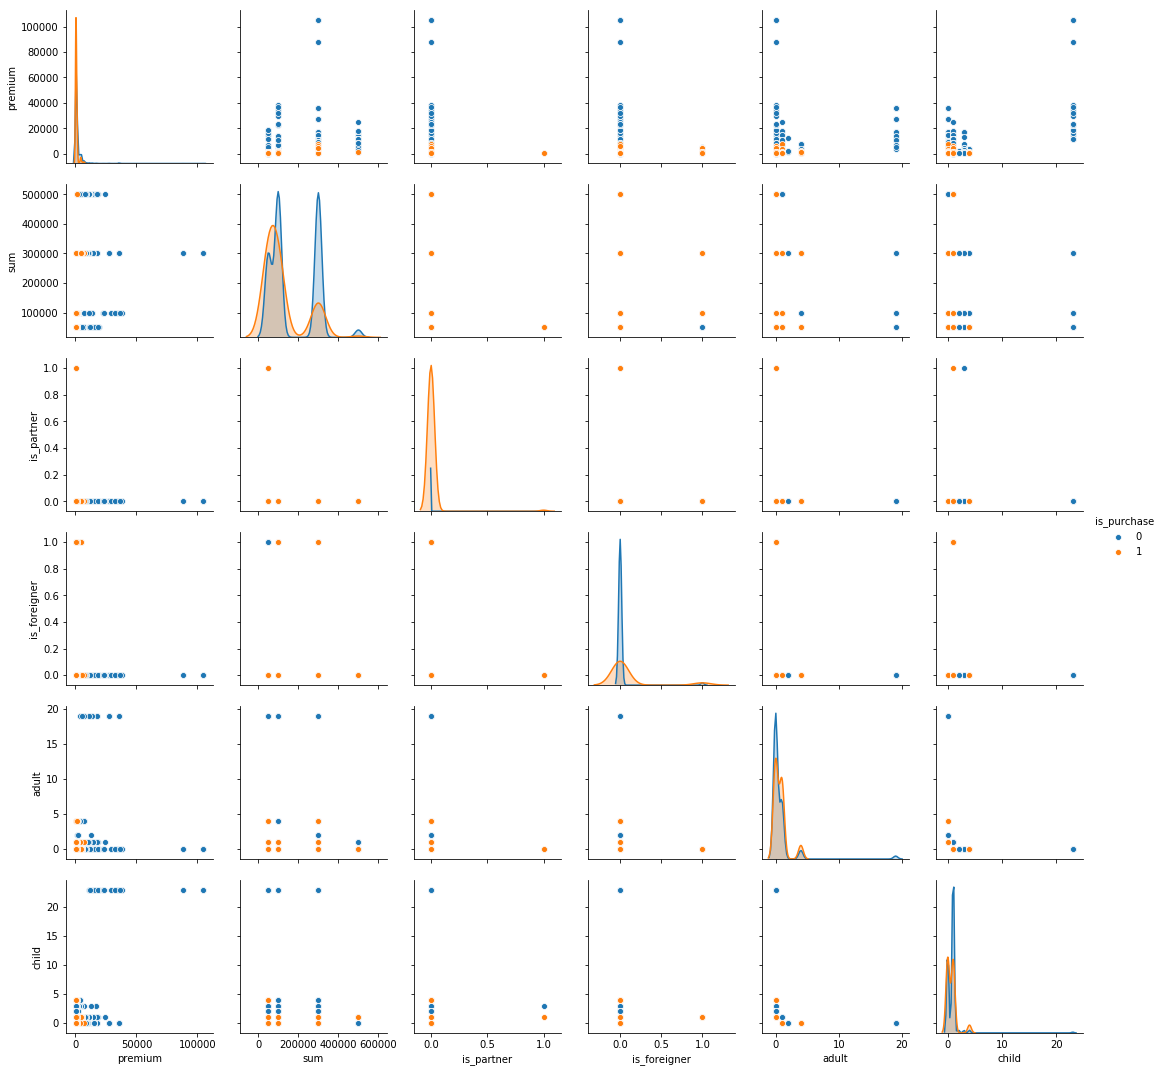

In [82]:
sns.pairplot(data, x_vars=['premium', 'sum', 'is_partner', 'is_foreigner', 'adult', 'child'],
                        y_vars=['premium', 'sum', 'is_partner', 'is_foreigner', 'adult', 'child'], hue='is_purchase')

In [22]:
def plot_user_agents(data):
    
    data = data.drop_duplicates(['key']).reset_index(drop=True)
    data['is_purchase'] = data['is_purchase'].map(lambda x: 1 if x == True else 0)
    data['not_purchase'] = data['is_purchase'].map(lambda x: 0 if x == True else 1)
    
    data['user_agent'] = data['user_agent'].map(lambda agent: \
        'Android' if re.search('Android', str(agent)) else \
        'iPhone' if re.search('iPhone', str(agent)) else \
        'Macintosh' if re.search('Macintosh', str(agent)) else \
        'Windows' if re.search('Windows', str(agent)) else \
        'Others'
    )
    
    data[data['is_purchase'] == 1].groupby('user_agent').agg('sum').plot(ax=axes[0] ,kind='bar', stacked=True, legend=None, color='g', title='Who buys more')
    data.groupby('user_agent').agg('sum')[['is_purchase', 'not_purchase']].plot(ax=axes[1] ,kind='bar', stacked=True, title='Deeper Cut', )

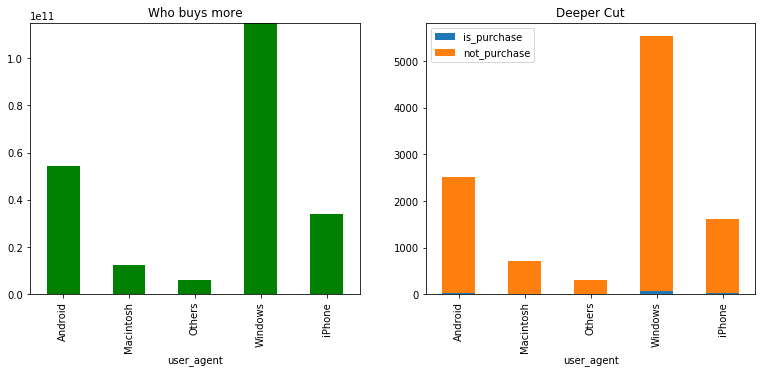

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
plot_user_agents(data)

In [2]:
class CompaniesTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        data__companies = self._find_num_companies(X)
        X = X.drop_duplicates(['key']).reset_index(drop=True)
        X['Num_of_companies'] = data__companies
        X.drop('key', axis=1, inplace=True)
        
        return X
    
    def _find_num_companies(self, data):
        keys = data.key.unique()
        data__companies = []
         
        for key in keys:
            data__companies.append(
                len(data[data['key'] == key].company.unique())
            )
            
        return data__companies

In [3]:
POSSIBLE_COLUMNS = ['Sport_AEROBIKA',
 'Sport_AEROBIKA, SPORTIVNAYA-AEROBIKA',
 'Sport_AEROBIKA, SPORTIVNAYA-AEROBIKA, SPORTIVNAYA-AKROBATIKA',
 'Sport_AEROTRUBA',
 'Sport_AEROTRUBA, PARASHYUTNYJ-SPORT',
 'Sport_AEROTRUBA, PARASHYUTNYJ-SPORT, LYZHNYJ-SPORT',
 'Sport_AJKIDO',
 'Sport_AKADEMICHESKAYA-GREBLYA',
 'Sport_AKROBATICHESKIJ-ROK-N-ROLL',
 'Sport_ALPINIZM-I-SKOLOLAZANIE',
 'Sport_AMERIKANSKIJ-FUTBOL',
 'Sport_ARMEJSKIJ-RUKOPASHNYJ-BOJ',
 'Sport_ARMRESLING',
 'Sport_AVTO-MOTO-SPORT-V-TCH-MOTOKROSS',
 'Sport_AVTOSPORT',
 'Sport_AVTOSPORT, AVTO-MOTO-SPORT-V-TCH-MOTOKROSS',
 'Sport_BADMINTON',
 'Sport_BALNYE-TANTSY',
 'Sport_BALNYE-TANTSY, TANTSY-SPORTIVNYE',
 'Sport_BASEJAMPING',
 'Sport_BASEJAMPING, PARASHYUTNYJ-SPORT',
 'Sport_BASKETBOL-V-TCH-KORFBOL-STRITBOL',
 'Sport_BASKETBOL-V-TCH-KORFBOL-STRITBOL, SAMBO--V-T-CH-BOEVOE-SAMBO---DZYUDO',
 'Sport_BASKETBOL-V-TCH-KORFBOL-STRITBOL, TKHEKVONDO',
 'Sport_BASKETBOL-V-TCH-KORFBOL-STRITBOL, VOLEJBOL',
 'Sport_BEG',
 'Sport_BEG, DETSKIY-LAGER',
 'Sport_BEG, PLAVANIE',
 'Sport_BEGOVYE-LYZHI',
 'Sport_BEGOVYE-LYZHI, BEGOVYE-LYZHI-LYZHEROLERNYJ-SPORT',
 'Sport_BEGOVYE-LYZHI, BEGOVYE-LYZHI-LYZHEROLERNYJ-SPORT, BEG',
 'Sport_BEGOVYE-LYZHI, KONNYJ-SPORT-VSE-VIDY-V-TCH-KONKUR',
 'Sport_BEGOVYE-LYZHI, KONNYJ-SPORT-VSE-VIDY-V-TCH-KONKUR, FUTBOL',
 'Sport_BMX',
 'Sport_BODIBILDING',
 'Sport_BOKS',
 'Sport_BORBA-NA-POYASAKH-KURASH',
 'Sport_CHIR-SPORT',
 'Sport_CHIRLIDING',
 'Sport_DAJVING-DO-40-METROV',
 'Sport_DARTS',
 'Sport_DETSKIY-LAGER',
 'Sport_DETSKIY-LAGER, BEG',
 'Sport_DZHIU-DZHITSU',
 'Sport_DZYUDO',
 'Sport_DZYUDO, DETSKIY-LAGER',
 'Sport_DZYUDO, DZHIU-DZHITSU',
 'Sport_DZYUDO, SAMBO--V-T-CH-BOEVOE-SAMBO---DZYUDO',
 'Sport_DZYUDO, SAMBO--V-T-CH-BOEVOE-SAMBO---DZYUDO, GREPPLING',
 'Sport_DZYUDO, SAMBO--V-T-CH-BOEVOE-SAMBO---DZYUDO, GREPPLING, PANKRATION',
 'Sport_DZYUDO, SAMBO--V-T-CH-BOEVOE-SAMBO---DZYUDO, TKHEKVONDO',
 'Sport_FEKHTOVANIE',
 'Sport_FIGURNOE-KATANIE',
 'Sport_FLAG---FUTBOL',
 'Sport_FRISTAJL',
 'Sport_FUTBOL',
 'Sport_FUTBOL, BASKETBOL-V-TCH-KORFBOL-STRITBOL',
 'Sport_FUTBOL, DETSKIY-LAGER',
 'Sport_FUTBOL, USHU',
 'Sport_GANDBOL',
 'Sport_GORNOLYZHNYJ-SPORT-V-TCH-GORNYE-LYZHI-SKOROSTNOJ-SPUSK-SLALOM',
 'Sport_GREBNYE-VIDY-SPORTA--GREBLYA-NA-BAJDARKAKH-KANOE-KAYAKAKH-I-TP',
 'Sport_GREBNYE-VIDY-SPORTA--GREBLYA-NA-BAJDARKAKH-KANOE-KAYAKAKH-I-TP, PLAVANIE',
 'Sport_GREKO-RIMSKAYA-BORBA',
 'Sport_KARATE-VSE-VIDY-V-TCH-KIOKUSINKAJ-KUDO-DZENDO-WKF',
 'Sport_KENDO',
 'Sport_KHOKKEJ',
 'Sport_KHUDOZHESTVENNAYA-GIMNASTIKA',
 'Sport_KIKBOKSING',
 'Sport_KONNYJ-SPORT-VSE-VIDY-V-TCH-KONKUR',
 'Sport_KONNYJ-SPORT-VSE-VIDY-V-TCH-KONKUR, DETSKIY-LAGER',
 'Sport_KUDO',
 'Sport_LEGKAYA-ATLETIKA',
 'Sport_LETNIJ-LAGER',
 'Sport_LYZHNYE-GONKI',
 'Sport_LYZHNYE-GONKI, BEGOVYE-LYZHI',
 'Sport_LYZHNYJ-SPORT',
 'Sport_LYZHNYJ-SPORT, AEROTRUBA, PARASHYUTNYJ-SPORT',
 'Sport_MINI-FUTBOL',
 'Sport_MINI-FUTBOL, SPORTIVNAYA-AKROBATIKA',
 'Sport_PANKRATION',
 'Sport_PARASHYUTNYJ-SPORT',
 'Sport_PAUERLIFTING',
 'Sport_PLAVANIE',
 'Sport_PLAVANIE, BEG',
 'Sport_PLAVANIE, LEGKAYA-ATLETIKA, LYZHNYE-GONKI, SVIMRAN-SWIMRUN-V-TCH-PLAVANIE-BEG',
 'Sport_PLAVANIE, PLAVANIE-S-LASTAMI',
 'Sport_PLAVANIE, TRIATLON',
 'Sport_PLAVANIE-S-LASTAMI',
 'Sport_PODVODNAYA-OKHOTA---RYBALKA',
 'Sport_POLIATLON',
 'Sport_PRYZHKI-NA-BATUTE-AKROBATICHESKOJ-DOROZHKE-I-DVOJNOM-MINITRAMPE',
 'Sport_REGBI',
 'Sport_RUKOPASHNYJ-BOJ',
 'Sport_RUKOPASHNYJ-BOJ, FUTBOL',
 'Sport_RYBOLOVNYJ-SPORT',
 'Sport_SAMBO--V-T-CH-BOEVOE-SAMBO---DZYUDO',
 'Sport_SAMBO--V-T-CH-BOEVOE-SAMBO---DZYUDO, DZYUDO',
 'Sport_SAMBO--V-T-CH-BOEVOE-SAMBO---DZYUDO, GREPPLING, PANKRATION',
 'Sport_SAMBO--V-T-CH-BOEVOE-SAMBO---DZYUDO, SMESHANNYE-BOEVYE-ISKUSSTVA--MMA-',
 'Sport_SEVERNOE-MNOGOBORE',
 'Sport_SHAKHMATY',
 'Sport_SHASHKI',
 'Sport_SHESTOVAYA-AKROBATIKA--POLDENS-POLE-DANCE-PILON-',
 'Sport_SINKHRONNOE-PLAVANIE',
 'Sport_SKALOLAZANIE-V-ZALE',
 'Sport_SMESHANNYE-BOEVYE-ISKUSSTVA--MMA-',
 'Sport_SNOUBORD-TRENIROVKI-SOREVNOVANIYA',
 'Sport_SPORTIVNAYA-AEROBIKA',
 'Sport_SPORTIVNAYA-AKROBATIKA',
 'Sport_SPORTIVNAYA-GIMNASTIKA',
 'Sport_SPORTIVNOE-ORIENTIROVANIE',
 "Sport_SPORTIVNYE-SOVREMENNYE-TANTSY-V-TCH-KHIP-KHOP-BREJK-DANS-R'N'B-I-TD",
 "Sport_SPORTIVNYE-SOVREMENNYE-TANTSY-V-TCH-KHIP-KHOP-BREJK-DANS-R'N'B-I-TD, PLAVANIE",
 "Sport_SPORTIVNYE-SOVREMENNYE-TANTSY-V-TCH-KHIP-KHOP-BREJK-DANS-R'N'B-I-TD, TANTSY-SPORTIVNYE",
 "Sport_SPORTIVNYE-SOVREMENNYE-TANTSY-V-TCH-KHIP-KHOP-BREJK-DANS-R'N'B-I-TD, TKHEKVONDO",
 'Sport_SPORTIVNYJ-TURIZM',
 'Sport_SPORTIVNYJ-TURIZM, AVTO-MOTO-SPORT-V-TCH-MOTOKROSS',
 'Sport_STRELBA-IZ-LUKA',
 'Sport_STRELKOVYJ-SPORT-V-TCH-PULEVAYA-STRELBA-STENDOVAYA-STRELBA-PRAKTICHESKAYA-STRELBA',
 'Sport_TAJSKIJ-BOKS',
 'Sport_TANTSY-SPORTIVNYE',
 'Sport_TENNIS',
 'Sport_TENNIS, BASKETBOL-V-TCH-KORFBOL-STRITBOL',
 'Sport_TENNIS, SHAKHMATY',
 'Sport_TENNIS, SHAKHMATY, BADMINTON',
 'Sport_TKHEKVONDO',
 'Sport_TKHEKVONDO, KHUDOZHESTVENNAYA-GIMNASTIKA',
 'Sport_TREKKING-KHAJKING',
 'Sport_TRIATLON',
 'Sport_TRIATLON, BEGOVYE-LYZHI, PLAVANIE, BEG',
 'Sport_TRIATLON, PLAVANIE',
 'Sport_TYAZHYOLAYA-ATLETIKA',
 'Sport_UNIVERSALNYJ-BOJ',
 'Sport_USHU',
 'Sport_VEJKSERF',
 'Sport_VELOSPORT-SHOSSE',
 'Sport_VELOSPORT-SHOSSE, KROSS-KANTRI',
 'Sport_VELOSPORT-SHOSSE, KROSS-KANTRI, MAUNTINBAJK---MTB-VSE-VIDY-V-TCH-DAUNKHIL-FRIRAJD-DERTDZHAMPING-STRIT---TRIAL',
 'Sport_VELOSPORT-SHOSSE, MAUNTINBAJK---MTB-VSE-VIDY-V-TCH-DAUNKHIL-FRIRAJD-DERTDZHAMPING-STRIT---TRIAL',
 'Sport_VELOSPORT-SHOSSE, VELOKROSS',
 'Sport_VESELYE-STARTY',
 'Sport_VODNO-MOTORNYJ-SPORT-V-TCH-AKVABAJK-SKUTER',
 'Sport_VOLEJBOL',
 'Sport_VOLEJBOL, BASKETBOL-V-TCH-KORFBOL-STRITBOL',
 'Sport_VOLEJBOL, PLYAZHNYJ-VOLEJBOL',
 'Sport_VOLNAYA-BORBA',
 'Sport_VOZDUSHNAYA-GIMNASTIKA',
 'Sport_YAKHTING-NE-OKEANSKIJ']

In [41]:
class SportTransform(BaseEstimator, TransformerMixin):
    
    possible_columns = POSSIBLE_COLUMNS
    
    def fit(self, X, y=None):
        
        sports_dummies = pd.get_dummies(X['sports'], prefix='Sport')
        self.possible_columns.extend([dummy for dummy in sports_dummies if dummy not in self.possible_columns])
        
        """
        with open('sport_types.pkl', 'w') as f:
            pickle.dump(self.possible_columns, f)
        """
        
        np.save('sport_types.npy', self.possible_columns)
        
        return self
    
    def transform(self, X, y=None):
        
        sports_dummies = pd.get_dummies(X['sports'], prefix='Sport')
        for column in self.possible_columns:
            if column in sports_dummies.columns:
                X[column] = sports_dummies[column]
            else:
                X[column] = np.zeros(X.shape[0], dtype=np.uint8)
        
        #X = pd.concat([X, sports_dummies], axis=1)
        X.drop('sports', axis=1, inplace=True)
        
        return X

In [5]:
class DurationTransform(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X['init_from__days'] = X['init_from'].map(lambda d: int(d.split('-')[2]))
        X['init_from__month'] = X['init_from'].map(lambda w: int(w.split('-')[1]))
        X['init_from__years'] = X['init_from'].map(lambda m: int(m.split('-')[0]))

        X['init_till__days'] = X['init_till'].map(lambda d: int(d.split('-')[2]))
        X['init_till__month'] = X['init_till'].map(lambda w: int(w.split('-')[1]))
        X['init_till__years'] = X['init_till'].map(lambda m: int(m.split('-')[0]))
        
        X['Length'] = (X['init_till__days'] - X['init_from__days']) + \
                        (X['init_till__month'] - X['init_from__month']) * 30 + \
                            (X['init_till__years'] - X['init_from__years']) * 365 + 1
        
        X.drop(['init_from__days', 'init_from__month', \
                   'init_from__years', 'init_till__days', \
                   'init_till__month', 'init_till__years', \
                   'init_from', 'init_till'], axis=1, inplace=True)
        
        X['Short_term'] = X['Length'].map(lambda l: 1 if l < 7 else 0)
        X['Middle_term'] = X['Length'].map(lambda l: 1 if 7 < l < 30  else 0)
        X['Long_term'] = X['Length'].map(lambda l: 1 if 30 < l else 0)
        
        X.drop('Length', axis=1, inplace=True)
        
        return X

In [6]:
class GroupTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X['Group_size'] = X['adult'] + X['child']
        
        X['Group_small'] = X['Group_size'].map(lambda x: 1 if x == 1 else 0)
        X['Group_middle'] = X['Group_size'].map(lambda x: 1 if 1 < x < 5 else 0)
        X['Group_large'] = X['Group_size'].map(lambda x: 1 if 10 < x else 0)
        
        X.drop(['Group_size', 'adult', 'child'], axis=1, inplace=True)
        
        return X

In [7]:
"""
Possible OSs:
    - Android
    - iPhone
    - Macintosh
    - Windows
"""

class UserAgentTransform(BaseEstimator, TransformerMixin):
    
    possible_columns = ['User_agent_Android', 'User_agent_Macintosh', \
                'User_agent_Others', 'User_agent_Windows', 'User_agent_iPhone']
    
    def fit(self, X, y=None):
        
        X['user_agent'] = X['user_agent'].map(lambda agent: \
            'Android' if re.search('Android', str(agent)) else \
            'iPhone' if re.search('iPhone', str(agent)) else \
            'Macintosh' if re.search('Macintosh', str(agent)) else \
            'Windows' if re.search('Windows', str(agent)) else \
            'Others'
        )
        
        user_agent_dummies = pd.get_dummies(X['user_agent'], prefix='User_agent')
        self.possible_columns.extend([dummy for dummy in user_agent_dummies if dummy not in self.possible_columns])
        
        
        return self
    
    def transform(self, X, y=None):
        
        X['user_agent'] = X['user_agent'].map(lambda agent: \
            'Android' if re.search('Android', str(agent)) else \
            'iPhone' if re.search('iPhone', str(agent)) else \
            'Macintosh' if re.search('Macintosh', str(agent)) else \
            'Windows' if re.search('Windows', str(agent)) else \
            'Others'
        )
        
        user_agent_dummies = pd.get_dummies(X['user_agent'], prefix='User_agent')
        
        for column in self.possible_columns:
            if column in user_agent_dummies.columns:
                X[column] = user_agent_dummies[column]
            else:
                X[column] = np.zeros(X.shape[0], dtype=np.uint8)
        
        #X = pd.concat([X, user_agent_dummies], axis=1)
        X.drop('user_agent', axis=1, inplace=True)
        
        return X

In [8]:
class DropingTransform(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X.drop(['status', 'company', 'premium', 'year', \
                'place', 'created_at', 'timezone', 'ip', \
                'referer', 'is_partner'], axis=1, inplace=True)
        
        return X

In [9]:
class BinaryTransform(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X['is_foreigner'] = X['is_foreigner'].map(lambda x: 1 if x == True else 0)
        X['is_adblock_enabled'] = X['is_adblock_enabled'].map(lambda x: 1 if x == True else 0)
        X['action_type'] = X['action_type'].map(lambda x: 1 if x == True else 0)
        #X['is_purchase'] = X['is_purchase'].map(lambda x: 1 if x == True else 0)
        
        return X

In [10]:
def split(data, train_size=0.8):
    
    y = data['is_purchase']
    X = data.drop('is_purchase', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
    
    return (X_train, X_test, y_train, y_test)

In [245]:
def score(y_test, y_pred):
    
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1 Score:', f1_score(y_test, y_pred))

In [51]:
pipeline = Pipeline([
    ('companies', CompaniesTransformer()),
    ('sports', SportTransform()),
    ('duration', DurationTransform()),
    ('group', GroupTransformer()),
    ('user_agent', UserAgentTransform()),
    ('binary', BinaryTransform()),
    ('droping', DropingTransform()),
])

In [52]:
data = pd.read_csv('out.csv')

In [53]:
data = pipeline.fit_transform(data)

In [55]:
y_train = data['is_purchase']
X_train = data.drop('is_purchase', axis=1)

In [57]:
clf = DecisionTreeClassifier(); clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [58]:
joblib.dump(clf, 'model.pkl')

['model.pkl']

In [368]:
def predict(data):
    
    keys = data.drop_duplicates(['key']).reset_index(drop=True)['key'].values
    data = pipeline.transform(data)
    
    if 'is_purchase' in data.columns:
        data.drop('is_purchase', axis=1, inplace=True)
        
    clf = joblib.load('model.pkl')
    predictions = clf.predict(data)
    
    results = {}
    for key, pred, in zip(keys, predictions):
        results[key] = pred
        
    return results

In [369]:
results = predict(data)
{k: results[k] for k in list(results)[:10]}

{4601: False,
 4603: False,
 4604: False,
 4605: False,
 4606: False,
 4607: False,
 4608: False,
 4609: False,
 4610: False,
 4611: False}